In [1]:
# --- Step 1: Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# For display settings
pd.set_option("display.max_columns", None)

In [2]:
# --- Step 2: Load Dataset ---
# Dataset: https://www.kaggle.com/datasets/carrie1/ecommerce-data
# Download dataset from Kaggle

import kagglehub
import os

# Download latest version
data_path = kagglehub.dataset_download("carrie1/ecommerce-data")

print("Path to dataset files:", data_path)

# List downloaded files
files = os.listdir(data_path)
print(files)

Path to dataset files: /Users/laxmanmaheshwaram/.cache/kagglehub/datasets/carrie1/ecommerce-data/versions/1
['data.csv']


In [3]:
# Load the dataset

#try:
    #df = pd.read_csv(os.path.join(data_path, 'data.csv'), encoding='latin1')
    #print("Dataset shape:", df.shape)
    #print(df.head())
#except UnicodeDecodeError:
    #print("Error with 'latin1' encoding. Trying 'ISO-8859-1'...")
    #df = pd.read_csv(os.path.join(data_path, 'data.csv'), encoding='ISO-8859-1')
    #print("Dataset shape:", df.shape)
    #print(df.head())
df = pd.read_csv(os.path.join(data_path, 'data.csv'),encoding='ISO-8859-1')
print("Dataset shape:", df.shape)
print(df.head())  # Display first 5 rows

Dataset shape: (541909, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [5]:
# --- Step 3: Data Cleaning ---
# Remove missing values
df.dropna(inplace=True)

# Check duplicated values
print(str(sum(df.duplicated())))

# Remove cancelled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Ensure InvoiceDate is datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove negative/zero quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

print("Cleaned dataset shape:", df.shape)

5225
Cleaned dataset shape: (397884, 8)


In [6]:
# --- Step 4: Feature Engineering (RFM Metrics) ---
# Reference date for Recency calculation: 1 day after the last invoice date
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Recency: days since last purchase
recency_df = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency_df['Recency'] = (reference_date - recency_df['InvoiceDate']).dt.days

# Frequency: total number of purchases
frequency_df = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']

# Monetary: total spend
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
monetary_df = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary_df.columns = ['CustomerID', 'Monetary']

# Merge RFM tables
rfm_df = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')
rfm_df.drop(columns=['InvoiceDate'], errors='ignore', inplace=True)

print("RFM shape:", rfm_df.shape)
rfm_df.head()

RFM shape: (4338, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [7]:
# --- Step 5: Standardization ---
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

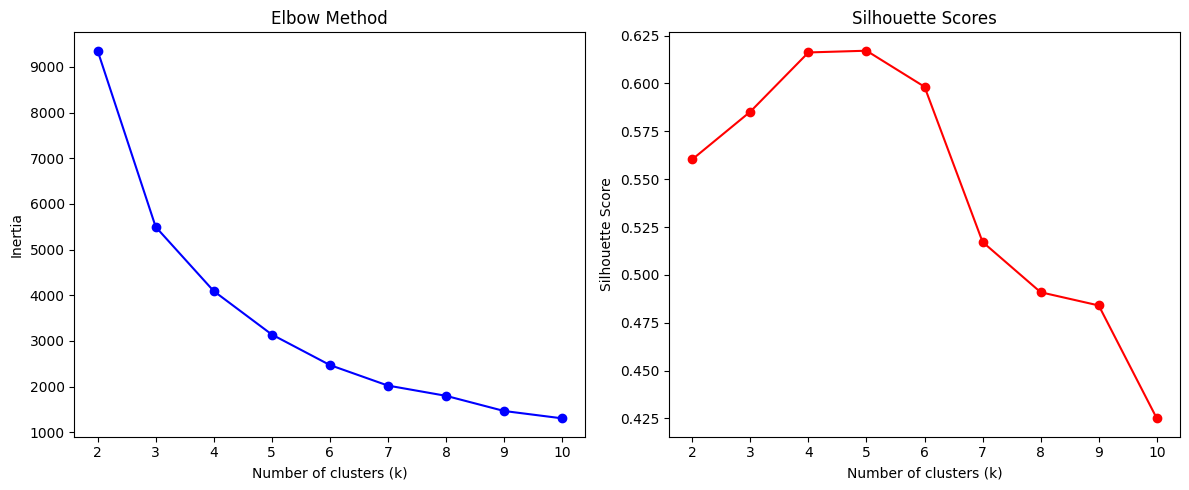

In [8]:
# --- Step 6: Clustering ---
# Determine optimal k using Elbow Method
inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Plot elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'ro-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')

plt.tight_layout()
plt.show()

# Choose optimal k (based on plots, adjust manually)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

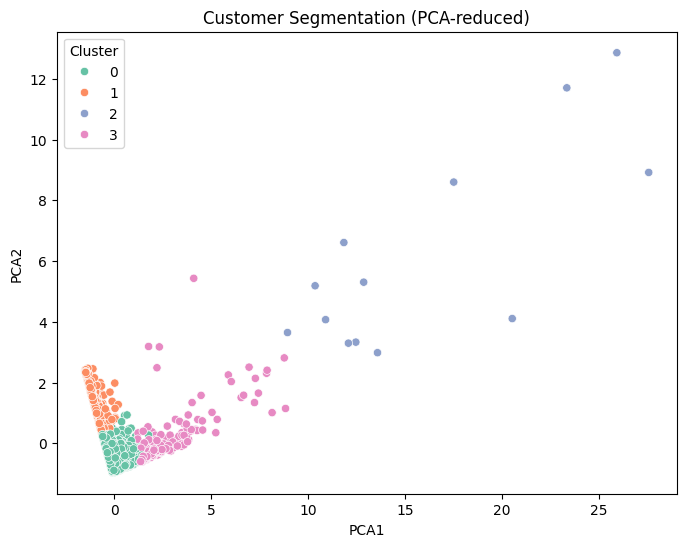

In [9]:
# --- Step 7: Visualization ---
# PCA for 2D plot
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
rfm_df['PCA1'] = rfm_pca[:, 0]
rfm_df['PCA2'] = rfm_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=rfm_df, palette='Set2')
plt.title('Customer Segmentation (PCA-reduced)')
plt.show()

In [10]:
# --- Step 8: Segment Analysis ---
segment_summary = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).reset_index()

print(segment_summary)

   Cluster     Recency  Frequency       Monetary  Count
0        0   43.702685   3.682711    1359.049284   3054
1        1  248.075914   1.552015     480.617480   1067
2        2    7.384615  82.538462  127338.313846     13
3        3   15.500000  22.333333   12709.090490    204
